##### VADER (Valence Aware Dictionary and sEntiment Reasoner) is a lexicon and rule-based sentiment analysis tool that is *specifically attuned to sentiments expressed in social media*. It is fully open-sourced under the `[MIT License]

In [2]:
#!pip install vaderSentiment

##### Python package to calculate statistics from text to determine readability, complexity and grade level of a particular corpus.

In [3]:
#!pip install textstat

In [4]:
import pandas as pd
import numpy as np
import pickle
import sys
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.stem.porter import *
import string
import re
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer as VS
from textstat.textstat import *
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import classification_report
from sklearn.svm import LinearSVC
import matplotlib.pyplot as plt
import seaborn
%matplotlib inline

In [5]:
df_tweets = pd.read_csv("labeled_data.csv")

In [6]:
df_tweets

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...
5,5,3,1,2,0,1,"!!!!!!!!!!!!!!!!!!""@T_Madison_x: The shit just..."
6,6,3,0,3,0,1,"!!!!!!""@__BrighterDays: I can not just sit up ..."
7,7,3,0,3,0,1,!!!!&#8220;@selfiequeenbri: cause I'm tired of...
8,8,3,0,3,0,1,""" &amp; you might not get ya bitch back &amp; ..."
9,9,3,1,2,0,1,""" @rhythmixx_ :hobbies include: fighting Maria..."


In [7]:
df_tweets.describe()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class
count,24783.000000,24783.000000,24783.000000,24783.000000,24783.000000,24783.000000
mean,12681.192027,3.243473,0.280515,2.413711,0.549247,1.110277
std,7299.553863,0.883060,0.631851,1.399459,1.113299,0.462089
min,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000
25%,6372.500000,3.000000,0.000000,2.000000,0.000000,1.000000
50%,12703.000000,3.000000,0.000000,3.000000,0.000000,1.000000
75%,18995.500000,3.000000,0.000000,3.000000,0.000000,1.000000
max,25296.000000,9.000000,7.000000,9.000000,9.000000,2.000000


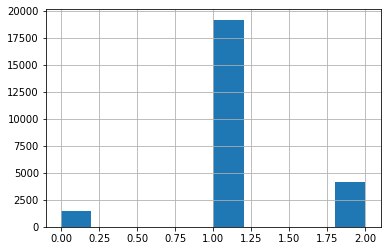

In [8]:
df_tweets['class'].hist()

<pre>This histogram shows the imbalanced nature of the task - most tweets containing "hate" words as defined by Hatebase were only considered to be offensive by the CF coders. More tweets were considered to be neither hate speech nor offensive language than were considered hate speech.</pre>

In [9]:
tweets=df_tweets.tweet

In [10]:
stopwords = nltk.corpus.stopwords.words("english")

other_exclusions = ["#ff", "ff", "rt"]
stopwords.extend(other_exclusions)

stemmer = PorterStemmer()


def preprocess(text_string):
    """
    Accepts a text string and replaces:
    1) urls with URLHERE
    2) lots of whitespace with one instance
    3) mentions with MENTIONHERE

    This allows us to get standardized counts of urls and mentions
    Without caring about specific people mentioned
    """
    space_pattern = '\s+'
    giant_url_regex = ('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|'
        '[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    mention_regex = '@[\w\-]+'
    parsed_text = re.sub(space_pattern, ' ', text_string)
    parsed_text = re.sub(giant_url_regex, '', parsed_text)
    parsed_text = re.sub(mention_regex, '', parsed_text)
    return parsed_text

In [11]:
def tokenize(tweet):
    """Removes punctuation & excess whitespace, sets to lowercase,
    and stems tweets. Returns a list of stemmed tokens."""
    tweet = " ".join(re.split("[^a-zA-Z]*", tweet.lower())).strip()
    tokens = [stemmer.stem(t) for t in tweet.split()]
    return tokens

def basic_tokenize(tweet):
    """Same as tokenize but without the stemming"""
    tweet = " ".join(re.split("[^a-zA-Z.,!?]*", tweet.lower())).strip()
    return tweet.split()

vectorizer = TfidfVectorizer(
    tokenizer=tokenize,
    preprocessor=preprocess,
    ngram_range=(1, 3),
    stop_words=stopwords,
    use_idf=True,
    smooth_idf=False,
    norm=None,
    decode_error='replace',
    max_features=10000,
    min_df=5,
    max_df=0.75
    )

In [12]:
#Construct tfidf matrix and get relevant scores
tfidf = vectorizer.fit_transform(tweets).toarray()
vocab = {v:i for i, v in enumerate(vectorizer.get_feature_names())}
idf_vals = vectorizer.idf_
idf_dict = {i:idf_vals[i] for i in vocab.values()} #keys are indices; values are IDF scores

C:\Users\GOLLAKOTA\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['b', 'c', 'e', 'f', 'g', 'h', 'j', 'l', 'n', 'p', 'r', 'u', 'v', 'w'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [13]:
print(idf_dict.values())

dict_values([1.2916307316034585, 3.907833585059827, 6.723464058558176, 4.6962909454240975, 6.127480626451879, 8.552963855769079, 7.899037388362414, 7.333723579312354, 8.920688635894397, 5.958857914016086, 6.473522314089243, 8.073390775507193, 9.172003064175302, 7.186087580506289, 6.61810354290035, 8.173474234064175, 1.782880397297114, 6.9747784868390825, 7.750617383244141, 8.2846998691744, 8.552963855769079, 8.920688635894397, 1.829223874843456, 4.748012230402388, 6.898405508054508, 6.990778828185523, 8.720017940432244, 7.454351567100969, 7.110580027998144, 9.172003064175302, 9.038471671550779, 2.4909691578552584, 5.242982482378585, 4.6995482772944035, 4.266728285736872, 5.04486867913021, 5.964621618732836, 4.6580087588530805, 7.429033759116678, 7.057470202684196, 4.742888393402518, 4.202189764599301, 6.094032692384339, 9.038471671550779, 4.530363198405819, 5.526926232719759, 6.959030129870943, 5.628975487073928, 8.633006563442613, 9.508475300796515, 5.451486525118183, 9.50847530079651

<pre>contains the pre-trained English [Part-of-Speech (POS]</pre>

In [12]:
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\GOLLAKOTA\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping taggers\averaged_perceptron_tagger.zip.


True

In [14]:
#Get POS tags for tweets and save as a string
tweet_tags = []
for t in tweets:
    tokens = basic_tokenize(preprocess(t))
    tags = nltk.pos_tag(tokens)
    tag_list = [x[1] for x in tags]
    tag_str = " ".join(tag_list)
    tweet_tags.append(tag_str)

In [15]:
tweet_tags

['. . . NN VBD DT NN DT NN NN VBD DT JJ NN NN JJ NN NN JJ JJ NN NN JJ NN NN IN JJ NN VBD DT NN VBP DT NN NN JJ NN NN NN VBZ DT NN NN VBP NN JJ NN NN NN JJ NN NN JJ JJ NN NN . DT NN NN DT NN DT NN DT JJ NN NN JJ NN NN JJ JJ NN VBZ DT NN WRB DT NN NN VBZ DT NN NN NN NN NN NN VBZ DT JJ NN NN JJ NN . . .',
 '. . . . . NN NN NN NN NN VBZ DT JJ NN NN NN NN NN . . . JJ NN VBD DT NN NN NN VBD DT NN NN NN NN NN JJ JJ NN NN VBP VBZ DT NN NN IN NN NN VBP NN NN NN NN NN NN VBZ DT JJ NN . .',
 '. . . . . . . NN NN VBZ DT JJ NN . . . . NN NN NN NN JJ NN NN NN NN NN JJ NN VBD DT NN NN VBP NN NN DT JJ NN NN NN NN NN VBD DT NN NN NN NN NN NN NN . UH NN JJ NN NN NN NN JJ NN JJ NN NN VBZ DT JJ NN NN NN VBP',
 '. . . . . . . . . NN NN NN NN NN NN NN NN NN NN NN VBP VBZ DT NN NN DT JJ NN NN',
 '. . . . . . . . . . . . . NN NN NN NN NN NN NN JJ VBP JJ NN JJ NN VBZ DT NN DT NN NN JJ NN NN IN NN NN VBP NN NN NN NN NN NN JJ NN IN NN NN VBP NN NN VBP NN NN NN NN VBZ DT NN NN NN NN VBD DT JJ NN NN NN NN NN VBP N

In [16]:
#We can use the TFIDF vectorizer to get a token matrix for the POS tags
pos_vectorizer = TfidfVectorizer(
    tokenizer=None,
    lowercase=False,
    preprocessor=None,
    ngram_range=(1, 3),
    stop_words=None,
    use_idf=False,
    smooth_idf=False,
    norm=None,
    decode_error='replace',
    max_features=5000,
    min_df=5,
    max_df=0.75,
    )

In [17]:
#Construct POS TF matrix and get vocab dict
pos = pos_vectorizer.fit_transform(pd.Series(tweet_tags)).toarray()
pos_vocab = {v:i for i, v in enumerate(pos_vectorizer.get_feature_names())}

In [18]:
sentiment_analyzer = VS()

In [19]:
def print_sentiment_scores(sentence):
    snt = sentiment_analyzer.polarity_scores(sentence)
    print("{:-<40} {}".format(sentence, str(snt)))

In [20]:
print_sentiment_scores("I just got a call from my boss - does he realise it's Saturday?")

I just got a call from my boss - does he realise it's Saturday? {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}


In [21]:
print_sentiment_scores("I really hate it")

I really hate it------------------------ {'neg': 0.666, 'neu': 0.334, 'pos': 0.0, 'compound': -0.6115}


In [22]:
print_sentiment_scores("That is not good")

That is not good------------------------ {'neg': 0.445, 'neu': 0.555, 'pos': 0.0, 'compound': -0.3412}


In [23]:
print_sentiment_scores("That is no good")

That is no good------------------------- {'neg': 0.31, 'neu': 0.282, 'pos': 0.408, 'compound': 0.1779}


In [24]:


def count_twitter_objs(text_string):
    space_pattern = '\s+'
    giant_url_regex = ('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|'
        '[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    mention_regex = '@[\w\-]+'
    hashtag_regex = '#[\w\-]+'
    parsed_text = re.sub(space_pattern, ' ', text_string)
    parsed_text = re.sub(giant_url_regex, 'URLHERE', parsed_text)
    parsed_text = re.sub(mention_regex, 'MENTIONHERE', parsed_text)
    parsed_text = re.sub(hashtag_regex, 'HASHTAGHERE', parsed_text)
    return(parsed_text.count('URLHERE'),parsed_text.count('MENTIONHERE'),parsed_text.count('HASHTAGHERE'))

def other_features(tweet):
    """This function takes a string and returns a list of features.
    These include Sentiment scores, Text and Readability scores,
    as well as Twitter specific features"""
    sentiment = sentiment_analyzer.polarity_scores(tweet)
    
    words = preprocess(tweet) #Get text only
    
    syllables = textstat.syllable_count(words)
    num_chars = sum(len(w) for w in words)
    num_chars_total = len(tweet)
    num_terms = len(tweet.split())
    num_words = len(words.split())
    avg_syl = round(float((syllables+0.001))/float(num_words+0.001),4)
    num_unique_terms = len(set(words.split()))
    
    ###Modified FK grade, where avg words per sentence is just num words/1
    FKRA = round(float(0.39 * float(num_words)/1.0) + float(11.8 * avg_syl) - 15.59,1)
    ##Modified FRE score, where sentence fixed to 1
    FRE = round(206.835 - 1.015*(float(num_words)/1.0) - (84.6*float(avg_syl)),2)
    
    twitter_objs = count_twitter_objs(tweet)
    retweet = 0
    if "rt" in words:
        retweet = 1
    features = [FKRA, FRE,syllables, avg_syl, num_chars, num_chars_total, num_terms, num_words,
                num_unique_terms, sentiment['neg'], sentiment['pos'], sentiment['neu'], sentiment['compound'],
                twitter_objs[2], twitter_objs[1],
                twitter_objs[0], retweet]
    #features = pandas.DataFrame(features)
    return features

def get_feature_array(tweets):
    feats=[]
    for t in tweets:
        feats.append(other_features(t))
    return np.array(feats)

In [25]:
other_features_names = ["FKRA", "FRE","num_syllables", "avg_syl_per_word", "num_chars", "num_chars_total", \
                        "num_terms", "num_words", "num_unique_words", "vader neg","vader pos","vader neu", \
                        "vader compound", "num_hashtags", "num_mentions", "num_urls", "is_retweet"]

In [26]:
feats = get_feature_array(tweets)

In [27]:
#Now join them all up
M = np.concatenate([tfidf,pos,feats],axis=1)

In [28]:
M.shape

(24783, 4023)

In [29]:
#Finally get a list of variable names
variables = ['']*len(vocab)
for k,v in vocab.items():
    variables[v] = k

pos_variables = ['']*len(pos_vocab)
for k,v in pos_vocab.items():
    pos_variables[v] = k

feature_names = variables+pos_variables+other_features_names


## Model

In [30]:
X = pd.DataFrame(M)
y = df_tweets['class'].astype(int)

In [31]:
from sklearn.model_selection import train_test_split


In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.1)

In [33]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.pipeline import Pipeline

In [34]:
import warnings
warnings.filterwarnings("ignore")

In [35]:
pipe = Pipeline(
        [('select', SelectFromModel(LogisticRegression(class_weight='balanced',
                                                  penalty="l2", C=100 ,multi_class='auto'))),
        ('model', LogisticRegression(multi_class='auto',class_weight='balanced',penalty='l2'))])

In [36]:
param_grid = [{}] # Optionally add parameters here

In [37]:
grid_search = GridSearchCV(pipe, 
                           param_grid,
                           cv=StratifiedKFold(n_splits=5, 
                                              random_state=42).split(X_train, y_train), 
                           verbose=2)

In [38]:
model = grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV]  ................................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ................................................. , total=  35.3s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   35.3s remaining:    0.0s


[CV] ................................................. , total=  36.1s
[CV]  ................................................................
[CV] ................................................. , total=  36.5s
[CV]  ................................................................
[CV] ................................................. , total=  53.1s
[CV]  ................................................................
[CV] ................................................. , total=  49.1s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  3.5min finished


In [39]:
y_preds = model.predict(X_test)

In [40]:
y_train_test=model.predict(X_train)

# Evaluation

### Training Accuracy

In [150]:
from sklearn.metrics import accuracy_score
accuracy_score(y_train,y_train_test)

0.874551649928264

## Testing Accuracy

In [151]:
accuracy_score(y_test,y_preds)

0.8144413069786204

In [152]:
report = classification_report(y_test, y_preds)

In [153]:
print(report)

              precision    recall  f1-score   support

           0       0.32      0.37      0.35       164
           1       0.91      0.87      0.89      1905
           2       0.65      0.73      0.69       410

    accuracy                           0.81      2479
   macro avg       0.63      0.66      0.64      2479
weighted avg       0.83      0.81      0.82      2479



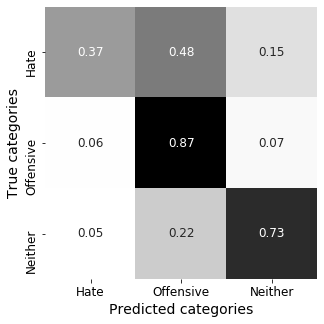

In [154]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test,y_preds)
matrix_proportions = np.zeros((3,3))
for i in range(0,3):
    matrix_proportions[i,:] = confusion_matrix[i,:]/float(confusion_matrix[i,:].sum())
names=['Hate','Offensive','Neither']
confusion_df = pd.DataFrame(matrix_proportions, index=names,columns=names)
plt.figure(figsize=(5,5))
seaborn.heatmap(confusion_df,annot=True,annot_kws={"size": 12},cmap='gist_gray_r',cbar=False, square=True,fmt='.2f')
plt.ylabel(r'True categories',fontsize=14)
plt.xlabel(r'Predicted categories',fontsize=14)
plt.tick_params(labelsize=12)